In [ ]:
%pip install opencv-python
%pip install tensorflow-addons[tensorflow]
%pip install keras

In [1]:
# Importing the libraries
import os
import gc
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import cv2
import csv
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa
from keras.callbacks import ModelCheckpoint

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [16]:
path="./jayakumarws.21/ViT-Malware-Detector-main - Copy/ViT-Malware-Detector-main/ExeImg_Dataset"
model_path="./jayakumarws.21/ViT-Malware-Detector-main - Copy/ViT-Malware-Detector-main/Model"
script_dir = os.path.dirname(os.path.abspath(''))
# Defining hyperparameters
num_classes = 2
input_shape = (299, 299, 3)
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 50
batch_size = 32
batch_testsize = 28
image_size = 128         					# We will resize the input images to this size
patch_size = 8           					# Size of the patches to be extracted from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 2							# number of attention heads
transformer_units = [projection_dim * 2, projection_dim,]        # Size of the transformer layers
transformer_layers = 1						# number of transformer layers
mlp_head_units = [2048, 1024]                                    # Size of the dense layers of the final classifier
key_dim = projection_dim // num_heads

# Creating the datasets
X = []
y = []
Files = ['Benignware', 'Malware']
label_val = 0

In [17]:
for files in Files:
    cpath = os.path.join(script_dir, path, files)
    for img in os.listdir(cpath):
        image_array = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)
        X.append(image_array)
        y.append(label_val)
    label_val = 1

In [18]:
Xhat = np.asarray(X[2:])
yhat = np.asarray(y[2:])
print(f"X: {Xhat.shape} - y: {yhat.shape}")
# Set aside 20% for test and the remaining for train and validation sets
X_train, X_test, y_train, y_test = train_test_split(Xhat, yhat, test_size=0.2, shuffle = True, random_state = 8)
# Set aside 10% for validation set and remaining for training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state= 8) 
# Checking the shape of the datasets
print(f"X_train: {X_train.shape} - y_train: {y_train.shape}")
print(f"X_val: {X_val.shape} - y_val: {y_val.shape}")
print(f"X_test: {X_test.shape} - y_test: {y_test.shape}")

X: (29466, 299, 299, 3) - y: (29466,)
X_train: (21214, 299, 299, 3) - y_train: (21214,)
X_val: (2358, 299, 299, 3) - y_val: (2358,)
X_test: (5894, 299, 299, 3) - y_test: (5894,)


In [19]:
del X
del y
del Xhat
del yhat
gc.collect()

637

In [20]:
STEP_SIZE_TRAIN = int( np.ceil(X_train.shape[0] / batch_size) )
STEP_SIZE_VALID = int( np.ceil(X_val.shape[0] / batch_size) )
STEP_SIZE_TEST = int( np.ceil(X_test.shape[0] / batch_testsize) )

In [21]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
    ],
    name="data_augmentation",
)

# Computing the mean and variance of the training data for normalization.  
data_augmentation.layers[0].adapt(X_train)

In [22]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [23]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
 
    def get_config(self):
        config = {
            "patch_size" : self.patch_size,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [24]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
 
    def get_config(self):
        config = {
            "num_patches" : self.num_patches,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
        
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [25]:
# Building Vision Transformer
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    print(f'Shape of inputs: {inputs.shape}')
    
    # Augment data
    augmented = data_augmentation(inputs)
    print(f'Shape of augmented: {augmented.shape}')
    
    # Create patches
    patches = Patches(patch_size)(augmented)
    print(f'Shape of patches: {patches.shape}')
    
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    print(f'Shape of encoded_patches: {encoded_patches.shape}')
    
    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=key_dim, value_dim=key_dim, use_bias = False, dropout=0.1
        )(x1, x1)
        print(f'Shape of attention_output: {attention_output.shape}')
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    print(f'Shape of mlp output: {features.shape}')
    # Classify outputs
    logits = layers.Dense(num_classes)(features)
    print(f'Shape of logits: {logits.shape}')
    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=logits)

    return model

In [26]:
def run_experiment(model):
    # Compiling the model
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Save the Keras model weights at some frequency (here, when the best validation accuracy is achieved)
    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
    )

    # Training the model

    history = model.fit(
        x=X_train,
        y=y_train,
        steps_per_epoch=STEP_SIZE_TRAIN,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(X_val,y_val),
        validation_steps=STEP_SIZE_VALID,
        callbacks=[checkpoint_callback],
        shuffle=True
    )
   
    # Save the model
    model.save(os.path.join(script_dir, model_path, "ViT_Model.keras"))
    
    # Checking the accuracy
    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test, batch_size=batch_testsize)
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    
    # Plotting the accuracies
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(os.path.join(script_dir, 'Accuracy.png'))
    plt.clf()
    
    # Plotting the loss
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(os.path.join(script_dir, 'Loss.png'))
    
    # Making predictions
    y_pred=model.predict(X_test, steps=STEP_SIZE_TEST)
    y_pred=np.argmax(y_pred,axis=1)
    
    labels = {'Benignware': 0, 'Malware': 1}
    print(f"Labels and their corresponding encodings: {labels}")
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in y_pred]
    print(f"Predictions: {y_pred}")
    print(f"Predictions: {predictions}")
    
    # Get the classification report
    print(classification_report(y_pred,y_test))
    # Get the confusion matrix
    print(confusion_matrix(y_pred,y_test))
    return history

In [27]:
vit_classifier = create_vit_classifier()
vit_classifier.summary()

Shape of inputs: (None, 299, 299, 3)
Shape of augmented: (None, 128, 128, 3)
Shape of patches: (None, None, 192)
Shape of encoded_patches: (None, 256, 64)
Shape of attention_output: (None, 256, 64)
Shape of mlp output: (None, 1024)
Shape of logits: (None, 2)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 128, 128, 3)          7         ['input_2[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches_1 (Patches)         (N

Epoch 1/50
663/663 [==============================] - 219s 328ms/step - loss: 0.2977 - accuracy: 0.9369 - top-5-accuracy: 1.0000 - val_loss: 0.0879 - val_accuracy: 0.9610 - val_top-5-accuracy: 1.0000
Epoch 2/50
663/663 [==============================] - 216s 326ms/step - loss: 0.0905 - accuracy: 0.9702 - top-5-accuracy: 1.0000 - val_loss: 0.1189 - val_accuracy: 0.9661 - val_top-5-accuracy: 1.0000
Epoch 3/50
663/663 [==============================] - 217s 327ms/step - loss: 0.0681 - accuracy: 0.9793 - top-5-accuracy: 1.0000 - val_loss: 0.0758 - val_accuracy: 0.9716 - val_top-5-accuracy: 1.0000
Epoch 4/50
663/663 [==============================] - 215s 324ms/step - loss: 0.0540 - accuracy: 0.9826 - top-5-accuracy: 1.0000 - val_loss: 0.0861 - val_accuracy: 0.9686 - val_top-5-accuracy: 1.0000
Epoch 5/50
663/663 [==============================] - 215s 324

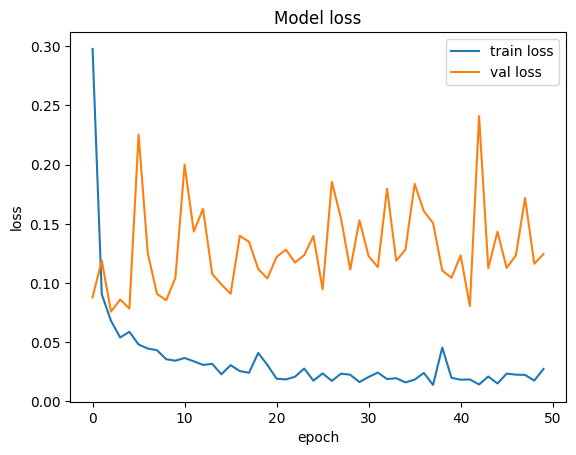

In [28]:
history = run_experiment(vit_classifier)